In [3]:
# !pip install pyLDAvis
# !pip install --upgrade pyLDAvis
# !pip install pyLDAvis.gensim
# pip install gensim nltk
# pip install nltk vaderSentiment


In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
import numpy as np
from gensim.models import CoherenceModel
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle

import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



# Visualize the topics
pyLDAvis.enable_notebook()






In [2]:
# Read in the data
tweets_df = pd.read_csv(r"C:\Users\user\PycharmProjects\TwitterAgeAlgorithm\sample.csv")
tweets_df.head(10)


,Name,Username,Date_Posted,Tweet,Reply_Count,Retweet_Count,Like_Count,Relations
0,Boba Inu,@BobaInu,Jun 1,Boba Inu's secret weapon? \nThe bear market! ...,12.0,29.0,46,friendship
1,Soccer Aid,@socceraid,Jun 4,Serious #SquadGoals for the Soccer Aid World X...,7.0,29.0,138,friendship
2,Céline,@Maelise16,Jun 4,"Two years ago,I ran on a relay half Cork city...",3.0,2.0,23,friendship
3,Paula Maier,@PaulaMaier3,May 31,My gym friend gave me this wonderful heart sha...,33.0,11.0,359,friendship
4,•ĐɆ฿Ɽ₳•,@RoseVioletDeb,Jun 3,Friends are the Sunshine of Life \n\n#Love #...,3.0,6.0,19,friendship
5,RappCats,@RappCatsAdopt,May 31,"Marigold & her best friend Tig. ""Where he goes...",12.0,72.0,396,friendship
6,Maggie Hall,@Hall_Mags,23h,After the running...what an amazing day in Cor...,NaN,5.0,13,friendship
7,CATIA CARDOSO Fan Account,@catiavacardoso,Jun 2,Knocking out the friend #mood #Friendship \n@...,NaN,1.0,16,friendship
8,★✧ 𝒜𝓁𝒾𝒸𝑒 ✧★,@Alice470971338,Jun 1,A friend who understands your tears is much mo...,4.0,17.0,43,friendship
9,อิควา(⁠人⁠*⁠´⁠∀⁠｀⁠)⁠｡⁠*ﾟ⁠+,@spicypricen,Jun 2,hi! i'm new to #studytwt *:･ﾟ✧\n\nabout me : \...,29.0,24.0,49,friendship


In [3]:
tweets_df.shape

(2578, 8)

## DATA CLEANING

In [4]:

# Removing duplicate tweets
tweets_df.drop_duplicates(subset="Tweet",keep="first",inplace=True)


In [5]:
# Remove symbols, numbers, and URL links
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lambda x: re.sub(r'\d+', '', x))
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lambda x: re.sub(r'https?://\S+', '', x))
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lambda x: re.sub(r'\d+', '', x))
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lambda x: re.sub(r'#\S+', '', x))
tweets_df["Tweet"]= tweets_df['Tweet'].replace(r'\r', ' ', regex=True)
tweets_df["Tweet"]= tweets_df['Tweet'].replace(r'\n', ' ', regex=True)


In [6]:
tweets_df["Tweet"]

0       Boba Inus secret weapon  The bear market   Wer...
1       Serious SquadGoals for the Soccer Aid World XI...
2       Two years agoI ran on a relay half  Cork city ...
3       My gym friend gave me this wonderful heart sha...
4        Friends are the Sunshine  of Life   Love Cari...
                              ...                        
2572    Thank you to all that have sacrificed for our ...
2573    u Dre took st places in the platinum bracket a...
2575    HappySunday stupidiot familyYou all know what ...
2576    Me and my Family are Homeless we really need s...
2577     Meal times are a great opportunity to enjoy c...
Name: Tweet, Length: 2436, dtype: object

In [7]:
# Remove emojis
def remove_emojis(Tweet):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', Tweet)

tweets_df['Tweet'] = tweets_df['Tweet'].apply(remove_emojis)



In [8]:
# Remove stop words and lemmatize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

nltk.download('punkt')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def process_text(Tweet):
    tokens = word_tokenize(Tweet)
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)
    

tweets_df['Tweet'] = tweets_df['Tweet'].apply(process_text)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
## removing non english words
nltk.download('words')
english_words = set(nltk.corpus.words.words())

# Define a function that takes in a string and returns a list of English words
def filter_english(Tweet):
    words = Tweet.split()
    english_words_x = [word for word in words if word in english_words]
    return ' '.join(english_words_x)

# Apply the function to the column to remove non-English words
tweets_df['Tweet'] = tweets_df['Tweet'].apply(filter_english)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [10]:
tweets_df[["Tweet"]]

,Tweet
0,boba secret weapon bear market season bulk acc...
1,serious soccer aid world xi see live old next
2,two year ran relay half cork city marathon wor...
3,gym friend gave wonderful heart shaped rock ta...
4,friend sunshine life love friendship
...,...
2572,thank country salute family
2573,u took st place platinum bracket memorial day ...
2575,know today party game day dont know many holid...
2576,family homeless really need help please anyone...


## TOPIC MODELLING USING LDA 1

## TOPIC MODELLING USING LDA 2

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (

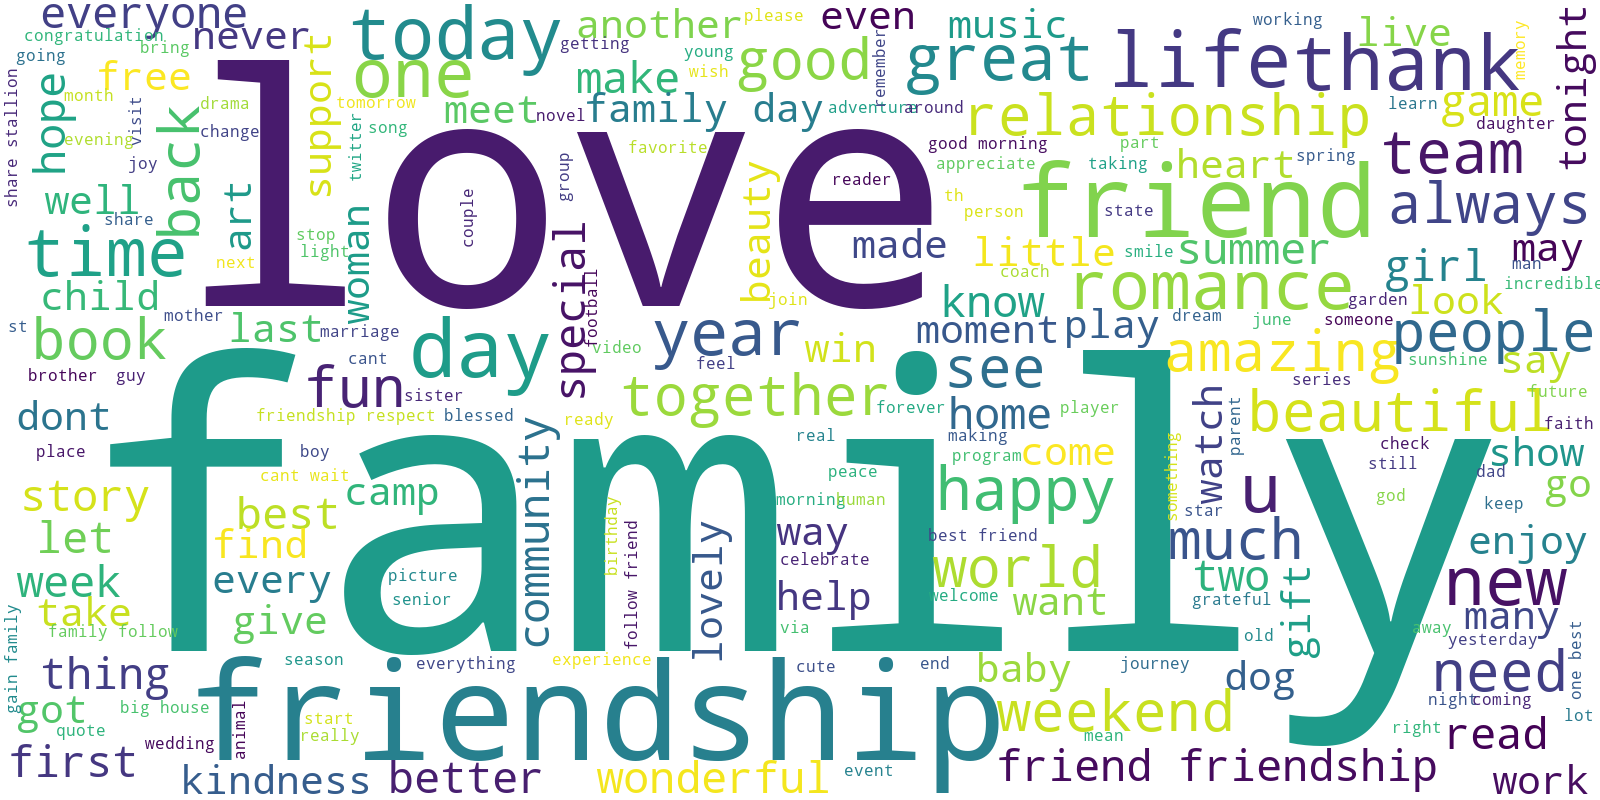

In [11]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',scale=4)
# Join the different processed titles together.
long_string = ','.join(list(tweets_df['Tweet'].values))
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        

In [13]:
# Create Dictionary
import gensim.corpora as corpora
data = tweets_df.Tweet.values.tolist()
data_words = list(sent_to_words(data))
# Create Corpus
id2word = corpora.Dictionary(data_words)
# Term Document Frequency
Tweet = data_words
corpus = [id2word.doc2bow(Tweet) for Tweet in Tweet]
# View
print(corpus[:1][0][:30])

# # Create a dictionary from the filtered documents
# dictionary = corpora.Dictionary(filtered_documents)
#
# # Convert the filtered documents to bag-of-words representation
# bow_corpus = [dictionary.doc2bow(doc) for doc in filtered_documents]




[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]


In [15]:
num_topics = 2
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=10)


In [16]:
for topic_id in range(num_topics):
    print(f"Topic #{topic_id + 1}:")
    print(lda_model.print_topic(topic_id))
    print()


Topic #1:
0.048*"family" + 0.011*"friendship" + 0.008*"time" + 0.008*"game" + 0.006*"day" + 0.006*"romance" + 0.006*"one" + 0.005*"love" + 0.005*"book" + 0.005*"new"

Topic #2:
0.066*"family" + 0.026*"love" + 0.016*"day" + 0.015*"friend" + 0.012*"friendship" + 0.007*"thank" + 0.007*"today" + 0.006*"good" + 0.006*"great" + 0.006*"happy"



## SENTIMENT ANALYSIS

In [17]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


True

In [18]:
# Create an instance of the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


In [19]:
# Iterate over the tweets and analyze the sentiment
sentiments = []
for tweet in tweets_df['Tweet']:
    sentiment_scores = sid.polarity_scores(tweet)
    sentiments.append(sentiment_scores)

# Create a new column in the DataFrame to store the sentiment scores
tweets_df['sentiment_scores'] = sentiments



In [21]:
# Define a function to interpret the sentiment scores
def get_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the get_sentiment function to the compound scores and create a new column for sentiment labels
tweets_df['sentiment'] = tweets_df['sentiment_scores'].apply(lambda x: get_sentiment(x['compound']))

# Print the DataFrame with sentiment labels
print(tweets_df[['Tweet', 'sentiment']])


                                                  Tweet sentiment
0     boba secret weapon bear market season bulk acc...  Negative
1         serious soccer aid world xi see live old next  Negative
2     two year ran relay half cork city marathon wor...  Positive
3     gym friend gave wonderful heart shaped rock ta...  Positive
4                  friend sunshine life love friendship  Positive
...                                                 ...       ...
2572                        thank country salute family  Positive
2573  u took st place platinum bracket memorial day ...  Positive
2575  know today party game day dont know many holid...  Positive
2576  family homeless really need help please anyone...  Positive
2577  meal time great opportunity enjoy chatting chi...  Positive

[2436 rows x 2 columns]


## WORD FREQUENCY

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [22]:
# Concatenate all text from the desired column in the DataFrame
text = ' '.join(tweets_df['Tweet'].tolist())

# Tokenize the text into individual words
tokens = word_tokenize(text.lower())

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]


In [24]:
from collections import Counter

# Count the frequency of each word
word_freq = Counter(tokens)

# Print the word frequency
for word, freq in word_freq.items():
    print(word, freq)


boba 1
secret 16
weapon 1
bear 3
market 2
season 30
bulk 1
accumulate 1
unleash 1
power 12
surge 1
bull 1
return 4
cat 29
dog 46
serious 6
soccer 5
aid 1
world 80
xi 1
see 82
live 42
old 27
next 54
two 58
year 120
ran 6
relay 1
half 6
cork 10
city 9
marathon 6
wore 1
proudly 4
border 3
solidarity 18
friendship 715
supporting 15
research 6
rare 7
disorder 2
gym 7
friend 433
gave 11
wonderful 51
heart 44
shaped 1
rock 6
take 54
surgery 3
week 73
bring 20
healing 8
earth 7
angel 8
sunshine 20
life 160
love 740
marigold 1
best 121
tig 1
go 60
never 47
far 18
behind 19
say 33
nova 7
pet 14
rescue 13
amazing 85
day 303
thanks 58
much 67
everyone 60
brilliant 7
international 10
choir 1
respect 44
knocking 1
mood 9
tear 16
valuable 4
lot 21
know 59
smile 21
hi 10
new 116
call 14
l 5
still 26
grade 3
moot 2
looking 31
window 5
train 3
today 151
case 5
forget 9
thinking 4
grateful 26
short 14
surround 2
people 86
inspire 10
make 94
laugh 8
fill 4
positivity 9
laughter 17
suggestion 2
long 17
nic

In [ ]:
# # Create two empty lists to store the word and frequency data
# word_list = []
# frequency_list = []
#
# # Iterate over the word frequency data
# for word, freq in word_freq.items():
#     word_list.append(word)
#     frequency_list.append(freq)
#
# # Create new columns in the DataFrame for word and frequency
# tweets_df['word'] = word_list
# tweets_df['Tweet']['frequency'] = frequency_list
#
# # Save the updated DataFrame to a new CSV file
# # df.to_csv('updated_file.csv', index=False)


## VISUALIZATION

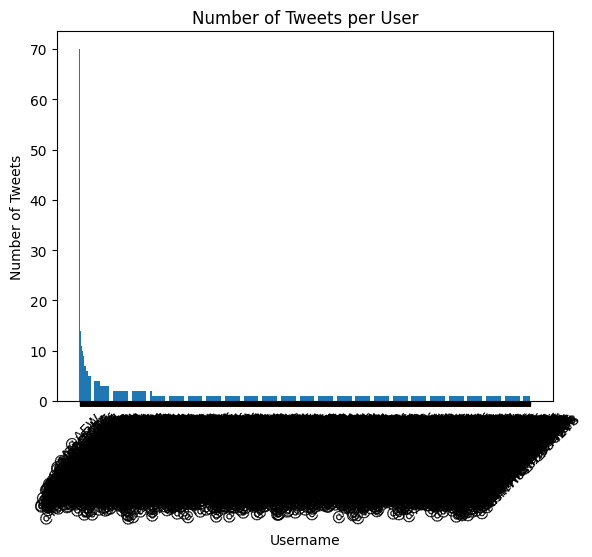

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Read the CSV file
tweets_df = pd.read_csv('sample.csv')

# Bar Chart - Number of tweets per user
user_tweet_counts = tweets_df['Username'].value_counts()
plt.bar(user_tweet_counts.index, user_tweet_counts.values)
plt.xlabel('Username')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per User')
plt.xticks(rotation=45)
plt.show()



In [29]:

# Pie Chart - Sentiment distribution
sentiment_counts = tweets_df['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()


KeyError: 'sentiment'

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (

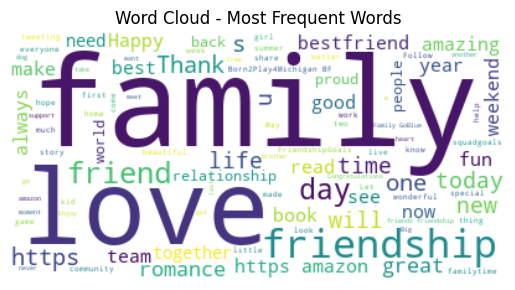

In [30]:

# Word Cloud - Most frequent words
text = ' '.join(tweets_df['Tweet'].tolist())
wordcloud = WordCloud(background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Most Frequent Words')
plt.show()



TypeError: 'value' must be an instance of str or bytes, not a float

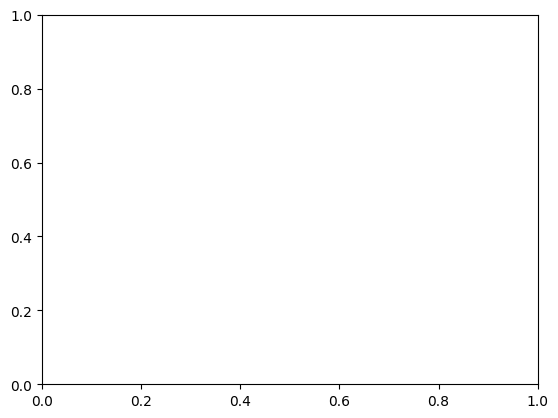

In [31]:
# Scatter Plot - Relationship between replies, retweets, and likes
plt.scatter(tweets_df['Reply_Count'], tweets_df['Retweet_Count'], s=tweets_df['Like_Count'], alpha=0.5)
plt.xlabel('Reply Count')
plt.ylabel('Retweet Count')
plt.title('Relationship between Replies, Retweets, and Likes')
plt.show()

In [32]:
# Network Graph - User connections based on mentions
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges between users based on mentions
for i, row in tweets_df.iterrows():
    user1 = row['Username']
    mentions = re.findall(r'@(\w+)', row['Tweet'])
    for user2 in mentions:
        G.add_edge(user1, user2)

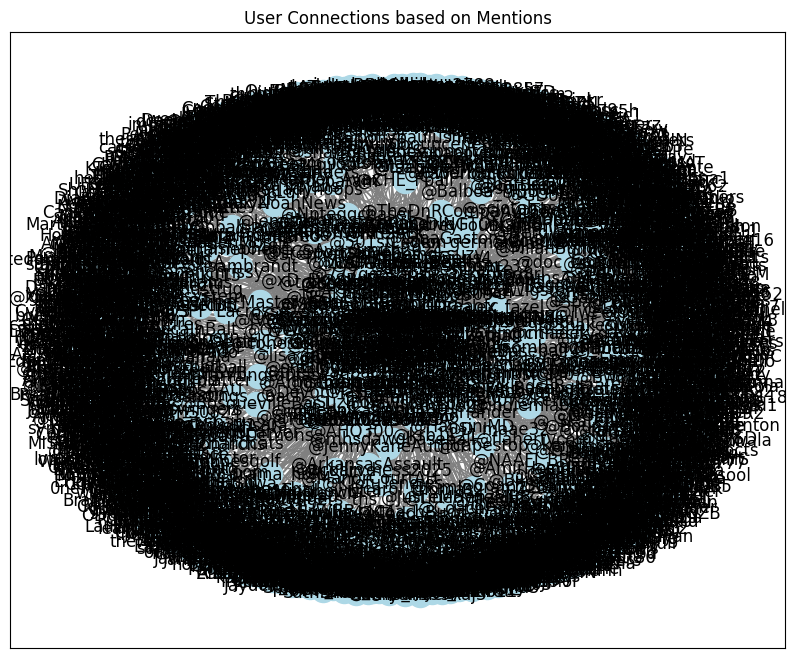

In [33]:
# Draw the network graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title('User Connections based on Mentions')
plt.show()

In [34]:
# Time Series Plot - Tweet activity over time
tweets_df['Date_Posted'] = pd.to_datetime(tweets_df['Date_Posted'])
daily_tweet_counts = tweets_df.groupby(tweets_df['Date_Posted'].dt.date)['Tweet'].count()
plt.plot(daily_tweet_counts.index, daily_tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Tweet Activity over Time')
plt.xticks(rotation=45)
plt.show()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: Jun 1, at position 0